In [1]:
import hashlib
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [2]:
def parse_files(root_path):
    files = root_path.joinpath("./train-output").glob("**/*.json")
    f1_results = []
    per_problem_results = []

    for file in files:

        file_data = json.loads(file.read_text())
        if not 'hyperparameters' in file_data:
            continue

        original_target = root_path.joinpath(file_data["original_target"])
        original_dict = json.loads(Path(original_target).read_text())

        f1_scores = file_data['f1_scores']

        hash_dict = lambda d: hashlib.sha256(json.dumps(d, sort_keys=True).encode()).hexdigest()

        for problem in file_data['per_problem'].keys():
            perf_per_fold = file_data['per_problem'][problem]
            for fold_performance in perf_per_fold:
                perf_per_fold = {**fold_performance, **original_dict, 'problem': problem,
                                 'hyperparameters': file_data['hyperparameters'],
                                 'hyperparameter_hash': hash_dict(file_data['hyperparameters'])}
                per_problem_results += [perf_per_fold]

        for fold, score in enumerate(f1_scores):
            results_dict = {
                "f1": score,
                "fold": fold,
                'hyperparameters': file_data['hyperparameters'],
                'hyperparameter_hash': hash_dict(file_data['hyperparameters'])
            }

            results_dict = {**results_dict, **original_dict}

            f1_results.append(results_dict)

    results_df = pd.DataFrame(f1_results)
    per_problem_df = pd.DataFrame(per_problem_results)
    # print(per_problem_df)

    return results_df, per_problem_df


In [3]:
data, per_problem = parse_files(Path('./analysis/'))

In [4]:
data.groupby(['model', 'hyperparameter_hash'])['f1'].mean().to_frame().reset_index()

,model,hyperparameter_hash,f1
0,AdaBoost,250558058f2c93ca037d39277c2dbfe11e313c1bfd7f9b...,0.725506
1,AdaBoost,2704acc7157a600701127edfa90c4147d1049007a44d8e...,0.717307
2,AdaBoost,31c0796c2921ae02cb3098c67476650fb1f9c2e1cd77e9...,0.610652
3,AdaBoost,812ed4653df6ff20098df22dc8eeb4204559430542cb4e...,0.664284
4,AdaBoost,870c4a0c19d7821cc8507f2fb7721df35eeb231968df82...,0.728418
5,AdaBoost,89ec8a9addf87f0ab0da1d7896228a44c0674576f240f5...,0.707883
6,DT,297afe2bad1763e839231109653c3c4bc7819a47700b8f...,0.700081
7,DT,621499a3f71726ca4f3f510378658c8987b79660796901...,0.701423
8,DT,b9d32f94c795efba9277b949cdd454832626b6338a5166...,0.707264
9,DUM,44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e...,0.281818


In [5]:
per_problem

,length,percentage,correct,use_gradient,use_ewma,model,k_fold,preprocessing,hyperparameters,problem,hyperparameter_hash
0,1,4,1.0,True,False,SVM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}","{'C': 1.0, 'kernel': 'rbf'}",rect_packing_mznc2014.mzn,a12825dff7e413984e1f31667ee453ee64be1d0782c42d...
1,1,4,1.0,True,False,SVM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}","{'C': 1.0, 'kernel': 'rbf'}",rect_packing_mznc2014.mzn,a12825dff7e413984e1f31667ee453ee64be1d0782c42d...
2,1,4,1.0,True,False,SVM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}","{'C': 1.0, 'kernel': 'rbf'}",rect_packing_mznc2014.mzn,a12825dff7e413984e1f31667ee453ee64be1d0782c42d...
3,2,4,1.0,True,False,SVM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}","{'C': 1.0, 'kernel': 'rbf'}",rect_packing_mznc2014.mzn,a12825dff7e413984e1f31667ee453ee64be1d0782c42d...
4,1,4,0.0,True,False,SVM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}","{'C': 1.0, 'kernel': 'rbf'}",rect_packing_opt.mzn,a12825dff7e413984e1f31667ee453ee64be1d0782c42d...
...,...,...,...,...,...,...,...,...,...,...,...
1727228,1,19,1.0,False,False,LR,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}",{'C': 1.0},square47.mzn,3a7347d85d926a59af87c244c1c09d1c92e009ba501297...
1727229,1,19,1.0,False,False,LR,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}",{'C': 1.0},square23.mzn,3a7347d85d926a59af87c244c1c09d1c92e009ba501297...
1727230,1,19,1.0,False,False,LR,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}",{'C': 1.0},rcmsp.mzn,3a7347d85d926a59af87c244c1c09d1c92e009ba501297...
1727231,1,19,0.0,False,False,LR,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}",{'C': 1.0},aflow40b.mzn,3a7347d85d926a59af87c244c1c09d1c92e009ba501297...


In [6]:
def select_hyperparameters(df, best=True):
    grouped = df.groupby(['percentage', 'model', 'use_ewma', 'use_gradient', 'hyperparameter_hash'])[
        'f1'].mean().reset_index()
    resulting_f1 = grouped.groupby(['percentage', 'model', 'use_ewma', 'use_gradient'])['f1'].idxmax() if best else \
        grouped.groupby(['percentage', 'model', 'use_ewma', 'use_gradient'])['f1'].idxmin()

    max_f1_rows = grouped.loc[resulting_f1]

    result_df = pd.merge(df, max_f1_rows[['percentage', 'model', 'use_ewma', 'use_gradient', 'hyperparameter_hash']],
                         on=['percentage', 'model', 'use_ewma', 'use_gradient', 'hyperparameter_hash'],
                         how='inner')

    return result_df


best_selected_models = select_hyperparameters(data)
worst_selected_models = select_hyperparameters(data, best=False)

In [7]:
worst_selected_models
# percent_5 = best_selected_models[best_selected_models["percentage"] == 5]
# percent_5.loc[percent_5['f1'].idxmax()]

,f1,fold,hyperparameters,hyperparameter_hash,percentage,use_gradient,use_ewma,model,k_fold,preprocessing
0,0.436364,0,{},44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e...,10,False,False,DUM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
1,0.327273,1,{},44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e...,10,False,False,DUM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
2,0.296296,2,{},44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e...,10,False,False,DUM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3,0.340426,3,{},44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e...,10,False,False,DUM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
4,0.339623,4,{},44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e...,10,False,False,DUM,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
...,...,...,...,...,...,...,...,...,...,...
6235,0.821053,5,"{'n_estimators': 200, 'max_depth': 10}",b129d3df0c6fa36e21c4934c90fe16e25e10648557a056...,3,False,False,ET,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
6236,0.824742,6,"{'n_estimators': 200, 'max_depth': 10}",b129d3df0c6fa36e21c4934c90fe16e25e10648557a056...,3,False,False,ET,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
6237,0.851064,7,"{'n_estimators': 200, 'max_depth': 10}",b129d3df0c6fa36e21c4934c90fe16e25e10648557a056...,3,False,False,ET,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
6238,0.844444,8,"{'n_estimators': 200, 'max_depth': 10}",b129d3df0c6fa36e21c4934c90fe16e25e10648557a056...,3,False,False,ET,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"


In [8]:
best_no_ewma_gradient = best_selected_models[~ best_selected_models['use_ewma'] & ~ best_selected_models['use_gradient']]

In [9]:
def plot_f1_each_model_with_error(df, models=None, ax=None):
    f1_df = df.groupby(['percentage', 'model'])['f1'].mean().sort_index()
    f1_std_df = df.groupby(['percentage', 'model'])['f1'].std().sort_index()
    
    # if models is not None:
        # f1_df = f1_df.loc[:, models]
        # f1_std_df = f1_std_df.loc[:, models]

    if ax is None:
        ax = plt.gca()

    # Add line and fillbetween for each model
    for model in f1_df.index.get_level_values('model').unique():
        o = 0.9
        if models is not None:
            if model not in models:
                o = 0.3
        mean = f1_df.loc[:, model]
        std = f1_std_df.loc[:, model]
        ax.errorbar(mean.index, mean, yerr=std, fmt=":", alpha=o, label=model, capsize=3, capthick=1)
        ax.fill_between(mean.index, mean - std, mean + std, alpha=0.1*o)
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 20)

    ax.set_xlabel("Percentage of TL")
    ax.set_ylabel("F1 score")
    ax.legend()
    ax.title.set_text("F1 score for each model over different percentages of TL")

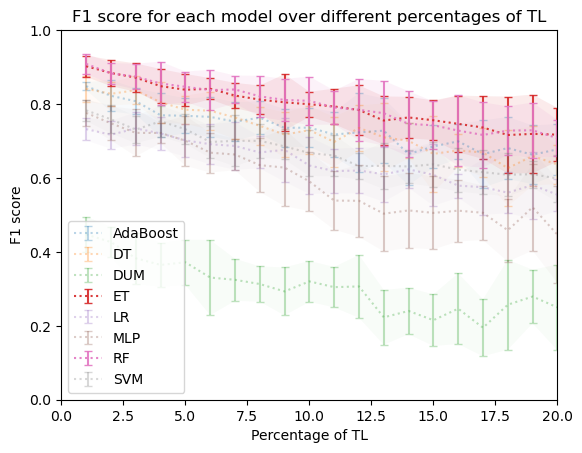

In [10]:
plot_f1_each_model_with_error(best_no_ewma_gradient, models=['ET', 'RF'])

<Axes: title={'center': 'F1 score for ET model with different hyperparameters over different percentages of TL'}, xlabel='percentage'>

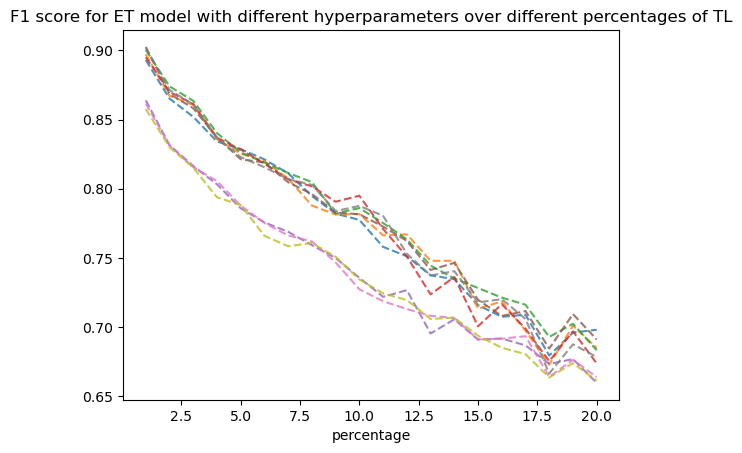

In [11]:
# Check different hyperparameters for ET model and see if the different models
# vary in performance over different percentages of TL
# Only show ET model
et_df = data[data['model'] == 'ET']
et_df = et_df.groupby(['percentage', 'hyperparameter_hash'])['f1'].mean()  #.sort_index()
et_df = et_df.unstack('hyperparameter_hash')
et_df.plot.line(linestyle="dashed", alpha=0.8, legend=False, title="F1 score for ET model with different hyperparameters over different percentages of TL")

In [12]:
best_no_ewma_gradient[(best_no_ewma_gradient['model'] == 'RF') & (best_no_ewma_gradient['percentage'] == 8)]

,f1,fold,hyperparameters,hyperparameter_hash,percentage,use_gradient,use_ewma,model,k_fold,preprocessing
3660,0.754717,0,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3661,0.814815,1,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3662,0.745098,2,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3663,0.807692,3,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3664,0.814815,4,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3665,0.949153,5,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3666,0.851852,6,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3667,0.821429,7,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3668,0.827586,8,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"
3669,0.821429,9,"{'n_estimators': 200, 'max_depth': None}",8530bd57f5ba5a6057cef33a5d3c99fd61f4429b0be428...,8,False,False,RF,{'n_splits': 10},"{'scale': True, 'drop_constant_values': True}"


In [13]:
best_selected_models.groupby(['percentage', 'model', 'use_ewma', 'use_gradient'])['hyperparameter_hash'].nunique()
best_selected_models.groupby(['percentage', 'model', 'use_ewma', 'use_gradient'])['hyperparameter_hash'].nunique()

percentage  model     use_ewma  use_gradient
1           AdaBoost  False     False           1
                      True      False           1
            DT        False     False           1
                      True      False           1
            DUM       False     False           1
                                               ..
20          RF        True      True            1
            SVM       False     False           1
                                True            1
                      True      False           1
                                True            1
Name: hyperparameter_hash, Length: 624, dtype: int64

# Visualisations

In [14]:
def label_ewma_and_gradients(df):
    def label(ewma, gradient):
        if ewma and gradient:
            return 'Both'
        elif ewma:
            return 'EWMA'
        elif gradient:
            return 'Gradient'
        else:
            return 'Neither'

    df['params_label_ewma_gradient'] = df.apply(lambda x: label(x['use_ewma'], x['use_gradient']), axis=1)
    return df

/tmp/ipykernel_55174/2766119172.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['params_label_ewma_gradient'] = df.apply(lambda x: label(x['use_ewma'], x['use_gradient']), axis=1)
/nix/store/479pigkfk8bfqiljn1wxz6ap01i99dgi-python3.10-seaborn-0.12.2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_55174/2766119172.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['params_label_e

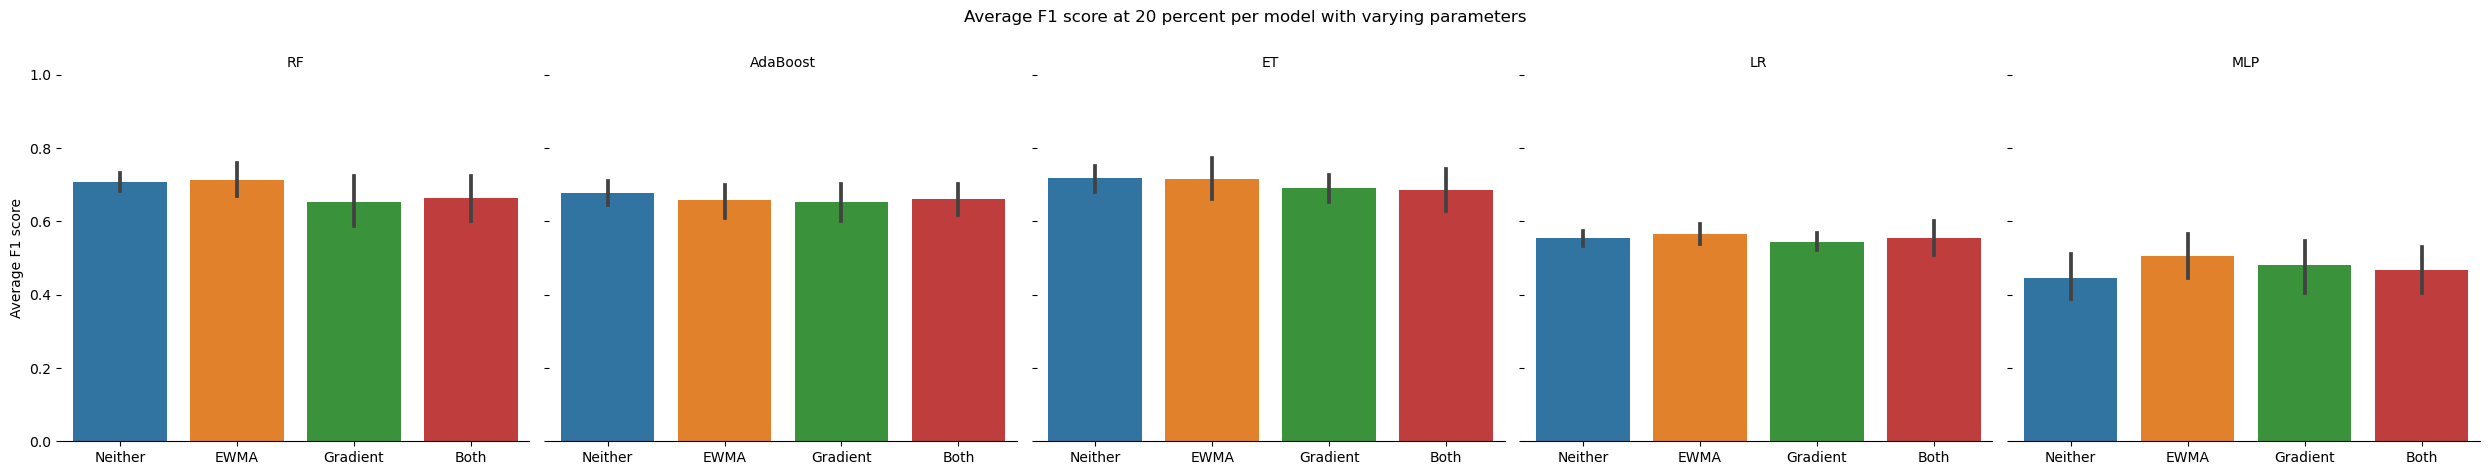

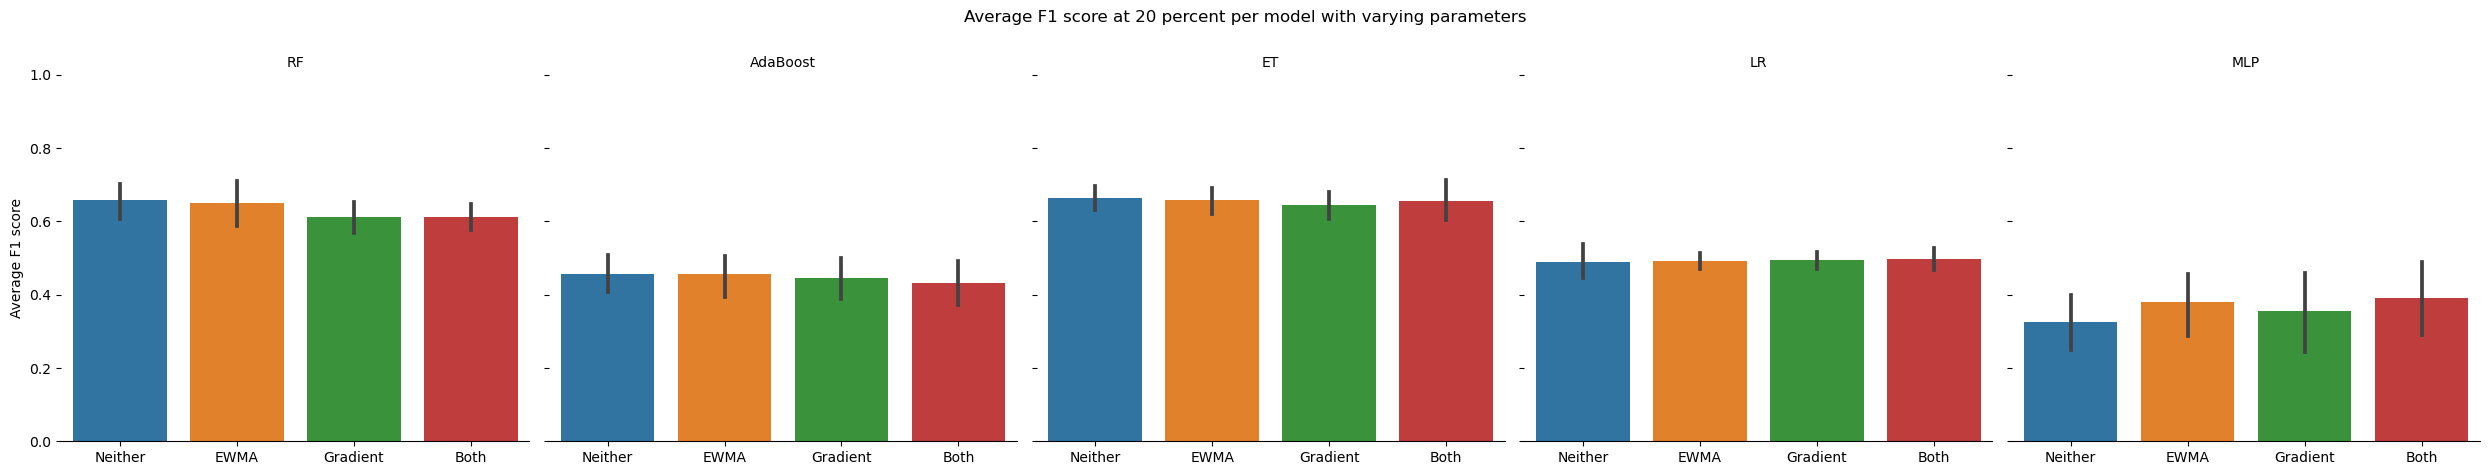

In [15]:
def plot_average_performance_at_x_percent(data_df, x):
    at_x_percent = data_df[data_df['percentage'] == x]
    trees_only = at_x_percent[at_x_percent['model'].isin(['RF', 'AdaBoost', 'ET', 'LR', 'MLP'])]
    labels_added = label_ewma_and_gradients(trees_only)

    # print(trees_only)
    g = seaborn.catplot(data=labels_added, errorbar=('ci', 90), x='params_label_ewma_gradient', y='f1', col='model', col_order=['RF', 'AdaBoost', 'ET', 'LR', 'MLP'],
                        kind='bar', order=['Neither', 'EWMA', 'Gradient', 'Both'])
    # for ax in g.axes.flat:
        # ax.set(yscale="log")

    plt.ylim(0, 1)
    g.set_axis_labels("", "Average F1 score") # (log scale)")
    g.set_titles("{col_name}")
    g.despine(left=True)

    plt.suptitle(f"Average F1 score at {x} percent per model with varying parameters")
    plt.subplots_adjust(top=0.85)

    # Show the plot


plot_average_performance_at_x_percent(best_selected_models, 20)
plot_average_performance_at_x_percent(worst_selected_models, 20)
plt.show()

/tmp/ipykernel_55174/2766119172.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['params_label_ewma_gradient'] = df.apply(lambda x: label(x['use_ewma'], x['use_gradient']), axis=1)


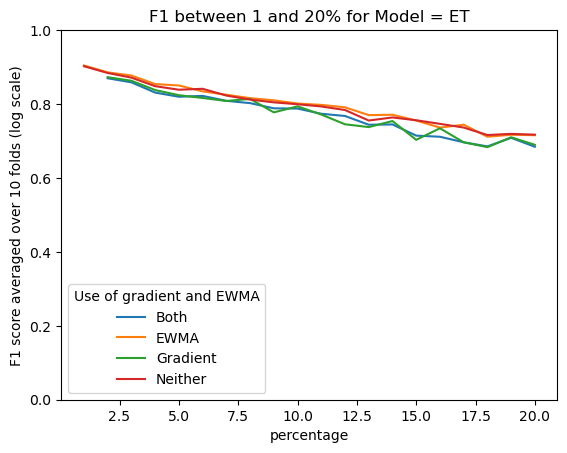

In [16]:
def plot_average_performance_between_percentages_inclusive(data_df, model, min_p, max_p):
    model_only = data_df[data_df['model'] == model]

    hues = ['Both', 'EWMA', 'Gradient', 'Neither']
    # hues = ['Neither']

    labels_added = label_ewma_and_gradients(model_only)
    labels_added = labels_added[
        labels_added['params_label_ewma_gradient'].isin(hues)]

    seaborn.lineplot(data=labels_added, x='percentage', y='f1', hue='params_label_ewma_gradient', errorbar=None,
                     hue_order=hues).set(
        title=f"F1 between {min_p} and {max_p}% for Model = {model}",
        ylabel="F1 score averaged over 10 folds (log scale)")
    plt.legend(title='Use of gradient and EWMA', loc='lower left')

    plt.ylim(0, 1)


def plot_best_and_worst(best, worst, model):
    plot_average_performance_between_percentages_inclusive(best, model, 1, 20)
    # plot_average_performance_between_percentages_inclusive(worst, model, 1, 20)
    plt.show()

plot_best_and_worst(best_selected_models, worst_selected_models, 'ET')

# plot_average_performance_between_percentages_inclusive(best_selected_models, 'ET', 1, 20)
# plot_average_performance_between_percentages_inclusive(best_selected_models, 'MLP', 1, 20)
# plot_average_performance_between_percentages_inclusive(best_selected_models, 'DUM', 1, 20)
# 
# plot_average_performance_between_percentages_inclusive(best_selected_models, 'AdaBoost', 1, 20)
# plot_average_performance_between_percentages_inclusive(best_selected_models, 'ET', 1, 20)
# plot_average_performance_between_percentages_inclusive(best_selected_models, 'MLP', 1, 20)
# plot_average_performance_between_percentages_inclusive(best_selected_models, 'DUM', 1, 20)


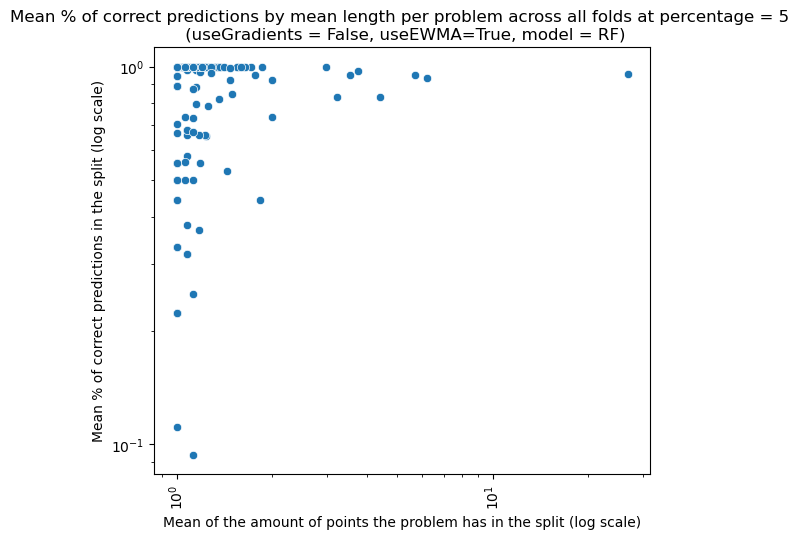

In [24]:
def scatterplot_length_vs_correct_per_problem(data_df, model, use_ewma, use_gradient):
    x = 5
    model_only = data_df[
        (data_df['percentage'] == x) & (data_df['model'] == model) & (data_df['use_ewma'] == use_ewma) & (
                data_df['use_gradient'] == use_gradient)]
    d = model_only.groupby(['problem'])[['length', 'correct']].mean()

    ax = seaborn.scatterplot(d, x='length', y='correct').set(
        title=f"Mean % of correct predictions by mean length per problem across all folds at percentage = {x} \n (useGradients = {use_gradient}, useEWMA={use_ewma}, model = {model})",
        ylabel="Mean % of correct predictions in the split (log scale)",
        xscale='log',
        yscale='log',
        xlabel="Mean of the amount of points the problem has in the split (log scale)")

    plt.xticks(rotation=90)

    plt.subplots_adjust(top=1)
    plt.show()


scatterplot_length_vs_correct_per_problem(per_problem, 'RF', True, False)

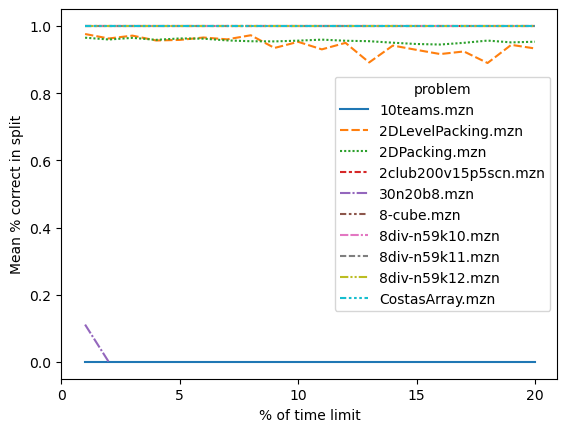

In [25]:
def line_graph_problem_vs_percentage(df, model, use_ewma, use_gradient):
    model_only = df[(df['model'] == model) & (df['use_ewma'] == use_ewma) & (df['use_gradient'] == use_gradient)]
    # Assuming you have the pivot table named 'pivot_table'
    pivot_table = model_only.pivot_table(index='percentage', columns='problem', values='correct', aggfunc='mean').iloc[
                  :, 0:10]

    ax = seaborn.lineplot(data=pivot_table, legend=True).set(
        ylabel="Mean % correct in split",
        xlabel="% of time limit",
        xticks=list(range(0, 21, 5))
    )

    # Show the plot
    plt.show()


# print(pivot_table)


#
# plt.xticks(rotation=90)
# plt.subplots_adjust(top=1)
# plt.show()
#


line_graph_problem_vs_percentage(per_problem, 'RF', False, False)